In [3]:
import time
print(time.time)

<built-in function time>


In [12]:
%matplotlib inline

In [13]:
from pylab import *

In [14]:
x = linspace(0,5,10)
y = x ** 2

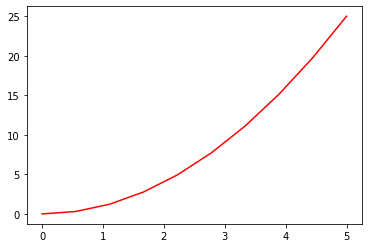

In [15]:
figure()
plot(x,y,'r')

In [17]:
import numpy as np

def gaussian_kernel(x1, x2, l=1.0, sigma_f=1.0):
    """Easy to understand but inefficient."""
    m, n = x1.shape[0], x2.shape[0]
    dist_matrix = np.zeros((m, n), dtype=float)
    for i in range(m):
        for j in range(n):
            dist_matrix[i][j] = np.sum((x1[i] - x2[j]) ** 2)
    return sigma_f ** 2 * np.exp(- 0.5 / l ** 2 * dist_matrix)

def gaussian_kernel_vectorization(x1, x2, l=1.0, sigma_f=1.0):
    """More efficient approach."""
    dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f ** 2 * np.exp(-0.5 / l ** 2 * dist_matrix)

x = np.array([700, 800, 1029]).reshape(-1, 1)
print(gaussian_kernel_vectorization(x, x, l=500, sigma_f=10))

[[100.          98.01986733  80.5347031 ]
 [ 98.01986733 100.          90.04307671]
 [ 80.5347031   90.04307671 100.        ]]


In [ ]:
from scipy.optimize import minimize




In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from scipy.optimize import minimize
import pandas as pd

class GPR:

    def __init__(self, optimize=True):
        self.is_fit = False
        self.train_X, self.train_y = None, None
        self.params = {"l": 0.5, "sigma_f": 0.2}
        self.optimize = optimize

    def fit(self, X, y):
        # store train data
        self.train_X = np.asarray(X)
        self.train_y = np.asarray(y)

         # hyper parameters optimization
        def negative_log_likelihood_loss(params):
            self.params["l"], self.params["sigma_f"] = params[0], params[1]
            Kyy = self.kernel(self.train_X, self.train_X) + 1e-8 * np.eye(len(self.train_X))
            loss = 0.5 * self.train_y.T.dot(np.linalg.inv(Kyy)).dot(self.train_y) + 0.5 * np.linalg.slogdet(Kyy)[1] + 0.5 * len(self.train_X) * np.log(2 * np.pi)
            return loss.ravel()

        if self.optimize:
            res = minimize(negative_log_likelihood_loss, [self.params["l"], self.params["sigma_f"]],
                   bounds=((1e-4, 1e4), (1e-4, 1e4)),
                   method='L-BFGS-B')
            self.params["l"], self.params["sigma_f"] = res.x[0], res.x[1]

        self.is_fit = True

    def predict(self, X):
        if not self.is_fit:
            print("GPR Model not fit yet.")
            return

        X = np.asarray(X)
        Kff = self.kernel(self.train_X, self.train_X)  # (N, N)
        Kyy = self.kernel(X, X)  # (k, k)
        Kfy = self.kernel(self.train_X, X)  # (N, k)
        Kff_inv = np.linalg.inv(Kff + 1e-8 * np.eye(len(self.train_X)))  # (N, N)

        mu = Kfy.T.dot(Kff_inv).dot(self.train_y)
        cov = Kyy - Kfy.T.dot(Kff_inv).dot(Kfy)
        return mu, cov

    def kernel(self, x1, x2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return self.params["sigma_f"] ** 2 * np.exp(-0.5 / self.params["l"] ** 2 * dist_matrix)
def writeXlsx(x,filename):
  data = pd.DataFrame(x)
  writer = pd.ExcelWriter(filename)		# 写入Excel文件
  data.to_excel(writer, 'page_1', float_format='%.5f')		# ‘page_1’是写入excel的sheet名
  writer.save()

filepath = 'data\data.xlsx'
df = pd.read_excel(filepath)
# print(df.head(2))
# df = df.head(5)
result = []
for i in df.index:  # 逐行读取
    # pre = df._get_value(i, 'pre')
    # w2 = df._get_value(i, '2W')
    # w4 = df._get_value(i, '4W')
    # w6 = df._get_value(i, '6W')
    # w8 = df._get_value(i, '8W')
    # w10 = df._get_value(i, '10W')
    # w12 = df._get_value(i, '12W')
    # print(pre,w2,w4,w6,w8,w10,w12)
    row = df.loc[i].values[0:-1]
    # print("row",row,type(row)) # numpy.ndarray
    row_new = np.zeros(14)
    for i in range(7):
        row_new[2*i] = row[i]
    # print("row_new",row_new,type(row_new)) # numpy.ndarray
    rowbool = np.isnan(row_new)
    # print("rowbool",rowbool)
    rowbool_rev = (rowbool == False) # 取反
    # print("rowbool_rev",rowbool_rev)
    rowbool_rev[1::2] = False
    # print("rowbool_rev",rowbool_rev)
    ind = np.where(rowbool_rev) # 所有为非空元素的下标
    # print("ind",ind)
    train_X = np.array(ind).reshape(-1, 1)
    # print("train_X",train_X)
    train_y = np.array(row_new[ind]).reshape(-1, 1)
    # print("train_y",train_y)
    l = 0
    r = 20
    step = 0.01
    test_X = np.arange(l, r, step).reshape(-1, 1)
    start = int((0-l)/step) # 有(r - l) / step这么多个点
    # print("start",start)
    ind_final = [start,start+int(1*2/step),start+int(2*2/step),
                 start+int(3*2/step),start+int(4*2/step),
                 start+int(5*2/step),start+int(6*2/step)]
    # print("ind_final",ind_final)
    # print(test_X)
    gpr = GPR(optimize=True)
    gpr.fit(train_X, train_y)
    mu, cov = gpr.predict(test_X)
    test_y = mu.ravel()
    # print("test_X",test_X,len(test_X))
    # print("test_y",type(test_y),test_y,len(test_y))
    print("test_y[ind_final]",test_y[ind_final])
    result.append(test_y[ind_final])
    # 画图
    # uncertainty = 1.96 * np.sqrt(np.diag(cov))
    # plt.figure()
    # plt.title("l=%.2f sigma_f=%.2f" % (gpr.params["l"], gpr.params["sigma_f"]))
    # plt.fill_between(test_X.ravel(), test_y + uncertainty, test_y - uncertainty, alpha=0.1)
    # plt.plot(test_X, test_y, label="predict")
    # plt.scatter(train_X, train_y, label="train", c="red", marker="x")
    # plt.legend()
print("result",result)
writeXlsx(result, filename='data/result.xlsx')

test_y[ind_final] [7.78300000e+01 2.61177784e-02 2.60000000e-02 8.72202833e-06
 3.67260801e-16 1.00638788e-06 3.00000000e-03]
test_y[ind_final] [5.36999999e+00 1.23000000e-01 3.88079193e-03 1.68000000e-01
 5.13688182e-03 9.05038565e-03 2.96000000e-01]
test_y[ind_final] [ 2.32900000e+01  1.92000000e-01 -4.09469726e-04  2.70000000e-02
  2.97059359e-04  6.60130328e-04  6.00000000e-02]
test_y[ind_final] [2.00000000e+01 6.70925256e-03 2.01277579e-05 6.00000000e-02
 2.01277577e-05 1.17411920e-05 3.50000000e-02]
test_y[ind_final] [4.65999999e+00 1.22000000e-01 9.99999997e-03 1.01895169e-03
 9.99999998e-03 8.67674360e-04 9.99999998e-03]
test_y[ind_final] [ 1.42800000e+01  6.28000000e-01 -2.05074785e-02 -5.95852720e-06
  2.45861386e-06  8.57295263e-03  1.30000000e-01]
test_y[ind_final] [5.39999999e+00 1.60000000e-01 2.99999998e-03 7.28749598e-04
 2.24264773e-03 3.79999999e-02 2.24249766e-03]
test_y[ind_final] [1.30160000e+01 3.61000000e-01 8.80000000e-02 5.30000000e-02
 7.88874122e-03 7.2000000